In [96]:
import numpy as np
from scipy import stats

In [217]:
dat = pd.read_csv("hots_distances.tab",sep="\t", header=None)
dat.columns = ["scaf", "start", "end", "island_dist", "scaf1", "start1", "end2", "chrom", "cstart", "cend", "huh", "dist"]
#dat.columns = ["scaf", "start", "end", "parent", "scaf1", "start1", "end2", "chrom", "cstart", "cend", "huh", "dist"]
dat = dat[(dat.cstart!=".") & (dat.cend!=".")].reset_index()
dat["cstart"] = dat["cstart"].astype(int)
dat["cend"]   = dat["cend"].astype(int)

In [218]:
def classify(d, ths):
    close, far = ths
    if d<=close:
        return "close"
    if d>=close and d<far:
        return "intermediate"
    if d>=far:
        return "far"

In [219]:
dat["promoter_bool"] = dat.apply(lambda row: classify(row.island_dist, [500,10e3]), axis=1)

In [220]:
genome = pd.read_csv("UNIGE_PanGut_3.0_HiC.fasta.fai",sep="\t", header=None)
genome.columns = ["chrom", "length", "huh", "huha", "hahu"]

In [221]:
ctype = pd.read_csv("corn_macro_micro_dnazoo.tab",sep="\t")
c = ctype.set_index("scaf")["nature"].to_dict()
dat["ctype"] = dat.scaf.map(c)

In [222]:
l = genome.set_index("chrom")["length"].to_dict()
dat["length"] = dat.chrom.map(l)

In [223]:
dat["pos_frac"] = dat.apply(lambda row: min(row.cstart/row["length"], (row["length"]-row.cend)/row["length"]), axis=1)
dat["frac"] = dat.apply(lambda row: row.cstart/row["length"], axis=1)

In [224]:
ps = {}
for ctype,subd in dat.groupby("ctype"):
    D, p_value = stats.kstest(subd.frac, 'uniform')
    ps[ctype] = p_value

KstestResult(statistic=0.007083452944061208, pvalue=0.6945237067475162)


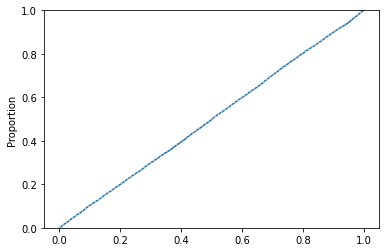

In [225]:
k = np.random.uniform(size=10000)
#k = [for l in k]
print(stats.kstest(k, "uniform"))
f,ax = plt.subplots()
sns.ecdfplot(k, ax=ax)
ax.axline((0,0), slope=1, 
          color="lightgray", 
          linestyle="dotted")

macro 8.401765562147593e-16
micro 8.224309470245975e-09


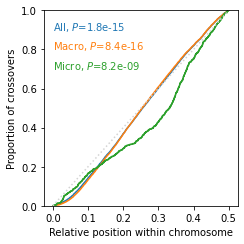

In [226]:
f,ax = plt.subplots(figsize=[3.5,3.5])

i = 0
D, p_value = stats.kstest(dat.frac, 'uniform')
sns.ecdfplot(data=dat, x="pos_frac", color=f"C{i}",ax=ax) 
ax.annotate("{}, $P$={:.1e}".format("All", p_value), xy=(0,0.9-(i*0.1)), color=f"C{i}")

for i,(ctype,subd) in enumerate(dat.groupby("ctype")):
    i = i+1
    D, p_value = stats.kstest(subd.frac, 'uniform')
    print(ctype, p_value)
    ps[ctype] = p_value
    sns.ecdfplot(data=subd, x="pos_frac", color=f"C{i}",ax=ax)
    if i==1:
        ax.annotate("{}, $P$={:.1e}".format(ctype.capitalize(), p_value), xy=(0,0.9-(i*0.1)), color=f"C{i}")
    if i==2:
        ax.annotate("{}, $P$={:.1e}".format(ctype.capitalize(), p_value), xy=(0,0.9-(i*0.1)), color=f"C{i}")
       
ax.axline((0,0), slope=2, 
          color="lightgray", 
          linestyle="dotted")

ax.set_ylabel("Proportion of crossovers")
ax.set_xlabel("Relative position within chromosome")
plt.tight_layout()
plt.savefig("cdf_hotspots.pdf")

In [227]:
dat = dat.replace("macro", "Macrochromosomes").replace("micro", "Microchromosomes")

/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


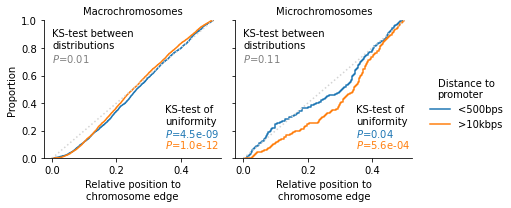

In [228]:
def ks(x, **kwargs):
    lx = 0.25
    ly = 0.25
    marg = 0.05
    D, p_value = stats.kstest(x, 'uniform')
    plt.annotate("$P$={:.3f}".format(p_value), xy=(lx,ly-(i*marg)))
    
subd = dat[dat.promoter_bool!="intermediate"]
g = sns.FacetGrid(data=subd, col="ctype", hue="promoter_bool")
g.map(sns.ecdfplot, "pos_frac")
#g.map(ks, "frac")

lx = 0.35
ly = 0.15
marg = 0.08
                                              
for i,(ctype,ax) in enumerate(g.axes_dict.items()):
    ssubd = subd[subd.ctype==ctype]
    ax.annotate("KS-test of\nuniformity", xy=(lx,ly+0.1))
    ax.axline((0,0), slope=2, 
          color="lightgray", 
          linestyle="dotted")    
    for i2,(prom, df) in enumerate(ssubd.groupby("promoter_bool")):
        D, p_value = stats.kstest(df.frac, 'uniform')
        if p_value<0.005:
            ax.annotate("$P$={:.1e}".format(p_value), xy=(lx,ly-(i2*marg)), 
                        color="C{}".format(i2))
        else:
            ax.annotate("$P$={:.2f}".format(p_value), xy=(lx,ly-(i2*marg)), 
                        color="C{}".format(i2))
    close = ssubd[ssubd.promoter_bool=="close"]
    far = ssubd[ssubd.promoter_bool=="far"]
    D,pval = stats.kstest(close.frac, far.frac)
    ax.annotate("KS-test between\ndistributions", xy=(0,0.8))
    ax.annotate("$P$={:.2f}".format(pval), xy=(0, 0.8-0.1), color="gray")

g.add_legend(title="Distance to\npromoter", labels=["<500bps", ">10kbps"])
g.set_titles(col_template = '{col_name}')
g.set_axis_labels("Relative position to\nchromosome edge")
g.tight_layout()
g.savefig("cdf_hotspots_prombool.jpg", dpi=200)

In [195]:
dat["sex"] = [s.split("-")[0] for s in dat.parent]

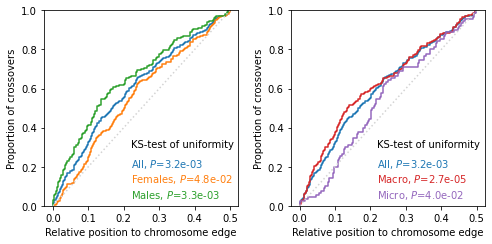

In [208]:
f,axs = plt.subplots(1,2, figsize=[7,3.5])

lx = 0.22
ly = 0.2
marg = 0.08

ax = axs[0]
i = 0
D, p_value = stats.kstest(dat.frac, 'uniform')
sns.ecdfplot(data=dat, x="pos_frac", color=f"C{i}",ax=ax) 
ax.annotate("KS-test of uniformity", xy=(lx,ly+0.1))
ax.annotate("{}, $P$={:.1e}".format("All", p_value), xy=(lx,ly-(i*0.08)), color=f"C{i}")

for i,(ctype,subd) in enumerate(dat.groupby("sex")):
    i = i+1
    D, p_value = stats.kstest(subd.frac, 'uniform')
    ps[ctype] = p_value
    sns.ecdfplot(data=subd, x="pos_frac", color=f"C{i}",ax=ax)
    if i==1:
        ax.annotate("{}, $P$={:.1e}".format("Females", p_value), xy=(lx,ly-(i*marg)), color=f"C{i}")
    if i==2:
        ax.annotate("{}, $P$={:.1e}".format("Males", p_value), xy=(lx,ly-(i*marg)), color=f"C{i}")
       
ax.axline((0,0), slope=2, 
          color="lightgray", 
          linestyle="dotted")

ax.set_ylabel("Proportion of crossovers")
ax.set_xlabel("Relative position to chromosome edge")

ax = axs[1]
i = 0
D, p_value = stats.kstest(dat.frac, 'uniform')
sns.ecdfplot(data=dat, x="pos_frac", color=f"C{i}",ax=ax) 
ax.annotate("KS-test of uniformity", xy=(lx,ly+0.1))
ax.annotate("{}, $P$={:.1e}".format("All", p_value), xy=(lx,ly-(i*0.1)), color=f"C{i}")


for i,(ctype,subd) in enumerate(dat.groupby("ctype")):
    i = i+1
    D, p_value = stats.kstest(subd.frac, 'uniform')
    ps[ctype] = p_value
    sns.ecdfplot(data=subd, x="pos_frac", color=f"C{i+2}",ax=ax)
    if i==1:
        ax.annotate("{}, $P$={:.1e}".format("Macro", p_value), xy=(lx,ly-(i*marg)), color=f"C3")
    if i==2:
        ax.annotate("{}, $P$={:.1e}".format("Micro", p_value), xy=(lx,ly-(i*marg)), color=f"C4")
       
ax.axline((0,0), slope=2, 
          color="lightgray", 
          linestyle="dotted")

ax.set_ylabel("Proportion of crossovers")
ax.set_xlabel("Relative position to chromosome edge")


plt.tight_layout()
plt.savefig("cdf_crossovers.jpg", dpi=200)